In [89]:
import utils
import keras
import model01
import datasets
import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
FILENAME = './output/MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5-200-0.6926.hdf5'

In [3]:
model = model01.MLPModel01.load(FILENAME)
# infers model description file from this filename
# loads model training history + weights from this specific file

AttributeError: class MLPModel01 has no attribute 'load'

In [4]:
model = keras.models.load_model(FILENAME)

In [5]:
pc = model01.ProgressCallback.load('MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5')

loading from file: ./output/MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5.npz


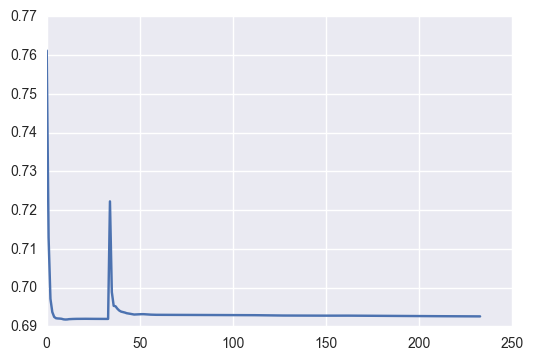

In [6]:
plt.plot(pc.validation_losses)

In [7]:
# load test dataset
lookahead=1
window=60
sym='USDJPY'
X_test, Y_test, prices_test, fut_return_test = datasets.load(datasets.filename('DS1', lookahead, window, sym, 2012))

In [8]:
Y_test_pred = model.predict(X_test.as_matrix(), batch_size=1024)
Y_test_pred_class = utils.prediction_to_category2(Y_test_pred)
metrics.performance_report("test",  prices_test,  lookahead, Y_test, Y_test_pred_class)

------------------------------------------------------
test
f1-score: 0.509
             precision    recall  f1-score   support

          0       0.52      0.41      0.46    177325
          1       0.51      0.62      0.56    176303

avg / total       0.52      0.51      0.51    353628



In [26]:
print "mean future return" , fut_return_test.mean()
#fut_return_test = fut_return_test - fut_return_test.mean()
(fut_return_test.ix[Y_test_pred_class[:,0]]+1).mean() - fut_return_test.mean() -1

mean future return 3.54963880531e-07


1.0409863877569592e-06

In [183]:
def perf(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    cats = utils.prediction_to_category2(preds)
    # turn true/false into +1/-1
    signs = cats*2 -1 
    
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [184]:
def perf2(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    # turn true/false into +1/-1
    signs = preds - 0.5
    
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [196]:
def perf3(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    # turn true/false into +1/-1
    signs = (preds - 0.5)
    signs = np.tanh(signs/2)
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [197]:
print perf(Y_test_pred, fut_return_test).sum()
print perf2(Y_test_pred, fut_return_test).sum()
print perf3(Y_test_pred, fut_return_test).sum()

0.0102211766714
0.483392359912
0.00748554765942
0.996552452866
0.00750170153011
0.996790324177


0.0102211766714
0.00748554765942
0.00750170153011


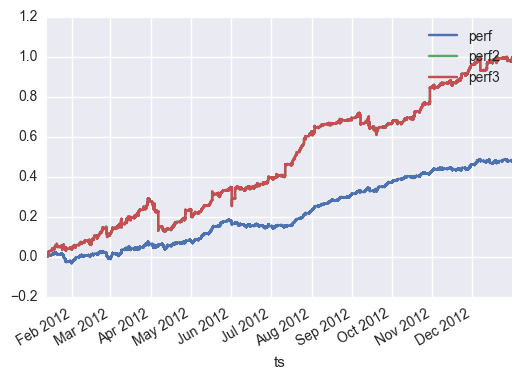

In [198]:
perf(Y_test_pred, fut_return_test).cumsum().plot(label='perf')
perf2(Y_test_pred, fut_return_test).cumsum().plot(label='perf2')
perf3(Y_test_pred, fut_return_test).cumsum().plot(label='perf3')
plt.legend()

-----------------------------------

## Control

In [16]:
X_control, Y_control, prices_control, fut_return_control = datasets.prepare_dataset1(df=datasets.random_ohlc(100000),lookahead=1, window=60)

In [17]:
X_test.describe()

,open-0,high-0,low-0,open-1,high-1,low-1,close-1,open-2,high-2,low-2,...,low-58,close-58,open-59,high-59,low-59,close-59,open-60,high-60,low-60,close-60
count,353628.000000,353628.000000,353628.000000,353628.000000,353628.000000,353628.000000,353628.000000,353628.000000,353628.000000,353628.000000,...,353628.000000,353628.000000,353628.000000,353628.000000,353628.000000,353628.000000,353628.000000,353628.000000,353628.000000,353628.000000
mean,-0.000787,0.005217,-0.005860,-0.001124,0.002283,-0.003794,-0.000756,-0.001424,0.001181,-0.003471,...,-0.008169,-0.007864,-0.008016,-0.007659,-0.008237,-0.007939,-0.008092,-0.007738,-0.008305,-0.008012
std,1.007626,1.002928,1.006705,1.008620,1.007895,1.008224,1.007476,1.009622,1.009129,1.009300,...,1.014397,1.014365,1.014392,1.014356,1.014419,1.014385,1.014422,1.014389,1.014450,1.014419
min,-30.145166,-0.835279,-37.771970,-44.456020,-48.726305,-47.928235,-53.512083,-38.413299,-41.561572,-40.403456,...,-10.144131,-10.217640,-9.975381,-10.064832,-9.997286,-10.072860,-9.996233,-9.914316,-9.990893,-9.914584
25%,-0.394757,-0.602334,-0.281343,-0.442930,-0.454843,-0.396688,-0.411887,-0.459051,-0.473061,-0.430440,...,-0.492126,-0.493527,-0.494294,-0.496404,-0.491683,-0.494500,-0.494077,-0.496234,-0.491883,-0.494333
50%,0.002414,-0.318139,0.325483,0.000168,-0.126291,0.124439,0.000341,-0.002641,-0.084436,0.083964,...,-0.004858,-0.012391,-0.012364,-0.020327,-0.004721,-0.012421,-0.012558,-0.020144,-0.004597,-0.011662
75%,0.391837,0.280659,0.614121,0.436307,0.390707,0.457487,0.405427,0.453391,0.426654,0.466969,...,0.475575,0.472761,0.472267,0.469648,0.476038,0.472556,0.472648,0.469672,0.476458,0.472732
max,36.457984,59.983059,0.869514,33.196071,36.517127,31.010189,36.433083,29.628341,34.768173,31.440586,...,13.725850,13.870061,13.642749,13.674089,13.622547,13.666291,13.510913,13.507446,13.556254,13.547526


In [18]:
X_control.describe()

,open-0,high-0,low-0,open-1,high-1,low-1,close-1,open-2,high-2,low-2,...,low-58,close-58,open-59,high-59,low-59,close-59,open-60,high-60,low-60,close-60
count,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,...,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000
mean,-0.000897,-0.001206,-0.001647,-0.001251,-0.001327,-0.001571,-0.000863,-0.001498,-0.001551,-0.001736,...,-0.005083,-0.004980,-0.005071,-0.005070,-0.005125,-0.005022,-0.005109,-0.005109,-0.005160,-0.005059
std,1.000340,1.000469,1.000173,0.999893,1.000090,0.999862,0.999819,0.999332,0.999445,0.999256,...,1.001050,1.001010,1.001184,1.001076,1.001119,1.001094,1.001237,1.001134,1.001173,1.001151
min,-4.138159,-0.989606,-5.925619,-4.511330,-4.160753,-4.905525,-4.369888,-4.299009,-4.282530,-4.500987,...,-3.880196,-3.956647,-3.950701,-3.933280,-3.900245,-3.914349,-4.125315,-4.052596,-4.083878,-4.020909
25%,-0.673194,-0.955700,-0.574048,-0.674786,-0.678754,-0.662807,-0.673236,-0.677553,-0.677407,-0.668709,...,-0.680133,-0.679812,-0.681854,-0.681321,-0.679400,-0.681371,-0.679451,-0.681124,-0.680549,-0.681947
50%,-0.000291,-0.251607,0.248150,-0.004047,-0.027215,0.015748,-0.003643,-0.005031,-0.012259,0.005821,...,-0.006013,-0.006935,-0.005167,-0.005002,-0.006433,-0.003538,-0.003001,-0.003334,-0.004734,-0.003186
75%,0.674541,0.576522,0.948055,0.669317,0.655297,0.683581,0.675738,0.673540,0.664316,0.674865,...,0.675560,0.674820,0.674008,0.675861,0.675571,0.676536,0.677067,0.675924,0.674915,0.674440
max,4.013959,5.762021,0.987367,4.428059,5.041230,3.704772,4.432290,4.110321,4.221380,4.224223,...,3.843375,3.834810,3.841711,3.781830,3.750507,3.726910,3.740519,3.766553,3.823016,3.799734


In [22]:
Y_control_pred = model.predict(X_control.as_matrix(), batch_size=1024)
Y_control_pred_class = utils.prediction_to_category2(Y_control_pred)
metrics.performance_report("control",  prices_control,  lookahead, Y_control, Y_control_pred_class)

------------------------------------------------------
control
f1-score: 0.496
             precision    recall  f1-score   support

          0       0.50      0.42      0.46     43831
          1       0.50      0.57      0.53     44111

avg / total       0.50      0.50      0.50     87942



In [25]:
(fut_return_control.ix[~Y_control_pred_class[:,0]]+1).mean() - fut_return_control.mean() - 1

2.6709233047483849e-08